<h1> ----------------------------------- Introduction ---------------------------------- </h1>

The following part would illustrate what I did during my summer internship (from 2018.05 ~ 2018.09) in <b>LangYou Asset Management</b> (https://www.lyam.cn/) which is a private equity fund firm located in Beijing, China. 

My job in this internship was to develop deep learning model to increase investment’s alpha. In detail, the model would either select some stocks among <b>CSI 300</b> or select some stocks among <b>CSI 500</b> respectively, and measure how much excess return I could get compared with corresonding Index. For people who are not familiar with Chinese stock market, below is a short introduction of about <b>CSI 300</b> and <b>CSI 500</b>

<b>CSI 300 </b>(http://www.csindex.com.cn/en/indices/index-detail/000300) is a capitalization-weighted stock market index designed to replicate the performance of top 300 stocks traded in the Shanghai and Shenzhen stock exchanges.


<b>CSI 500 Index </b>(http://www.csindex.com.cn/en/indices/index-detail/000905) consists of the largest remaining 500 A-Share stocks after excluding both the CSI 300 Index constituents and the largest 300 stocks. The Index reflects the overall performance of small-mid cap A-shares.



<b>Please note: All of the key code will not be shown in this notebook.</b>



There are total 800(CSI 300 + CSI 500) stocks are used to train the deep learning model.
The original data for each stock is histrical intraday 3-mins price and volume data from 2007 to 2017.
Let's take a look

In [10]:
import pandas as pd
pd.read_csv('../data/origin/CSI_500_Index_2007-2017_3mins_jian_adjusted_price/sh600004.csv',header=None,
           index_col=[0], usecols=[0,1,2], names=['time','price','volume'], parse_dates=[0]).head(50)

,price,volume
time,,
2007-01-04 09:27:00,2.919,1161
2007-01-04 09:33:00,2.946,5477
2007-01-04 09:36:00,2.891,2249
2007-01-04 09:39:00,2.891,3145
2007-01-04 09:42:00,2.898,2020
2007-01-04 09:45:00,2.912,2413
2007-01-04 09:48:00,2.891,1700
2007-01-04 09:51:00,2.912,2383
2007-01-04 09:54:00,2.967,4897


<h1> ----------------------------------- Data Preparation ---------------------------------- </h1>

The original data will be processed to fit the model for training.
For each stock
1. The day that reaches daily functuation limit(+10% or -10%) is dropped
2. The day that missing too much price and volume information is dropped
3. Deal will missing value (the day has a few price and volume ticks missed)
4. Transform stock price time series to denosie

All of these tasks is handled by generate_data function in <b>Process_stock_file.py file which isn't showed</b> in this post.

Before calling the function, the trading_time needed to be defined. I choosed 14:48:00 (the closing time is 15:00:00) and different trading_time will cause different target value.


In [2]:
from Process_stock_file import generate_data

trading_time = 75
# equivalent to 14:48:00
from_dir_name = '../data/origin/CSI_300_Index_2007-2017_3mins_hou_adjusted_price/'
to_dir_name = '../data/processed/CSI_300_Index_2007-2017_3mins_hou_adjusted_price/'
generate_data(from_dir_name,to_dir_name,trading_time)


from_dir_name = '../data/origin/CSI_500_Index_2007-2017_3mins_hou_adjusted_price/'
to_dir_name = '../data/processed/CSI_500_Index_2007-2017_3mins_hou_adjusted_price/'
generate_data(from_dir_name,to_dir_name,trading_time)


<h1> -------------------------- Deep Learning Model Developmen ----------------------</h1>

<h3>The deep learning model I developed is based on Rnn( acturally is GRU), but I made some modification to it.</h3>

<b>At first, I tried the GRU model, the result wasn't appealing. Then I found there is a drawback of RNN when the stock price series are fitted to it. Unlike the word vector which each number in the vector is not chronological order, but the daily stock vector I generated is in chronological order. Although RNN are good at catching the chronological relationship between sequcential vector, it's hard to find the the relationship of each number within the same vector. The model I developed not only can find detect reltionship between different vector but also the relationship of the number within the same vector.</b>

The model will give a value to each stock representing how likely or how much the stock will grow or decrease in the following serveral days.

<h4> There are total 2 models I developed stored in Rnn.py (not shown in this post)</h4>

<h1> ------------------------------------- Training ------------------------------------------</h1>
<h3>This sector will show how to train the model.</h3>
The training process will take 7 parameters as input.
1. model_start_day: the day when you want to start to use the model.
2. major_stock_dir_name: the list of stocks file paths which are used to training the model. Also the model will be used to predict these stocks' movement.
3. minor_stock_dir_name: the list of stocks file paths which serve as the supplement for the training dataset. But the model may not make any prediction on this stocks.
4. model_dir_name: the location where you want to store the result.
5. num_day_advance:predict how the stock will change in the following <i>num_day_advance</i> business days. 
6. delta_t: the number of previous days you want to use to make prediction. 
7. max_training_times: the maximum number of training times.
8. is_random: train the model in chronological way or not.



The following part trained models whose starting days are '2014-01-01','2014-07-01','2015-01-01','2015-07-01','2016-01-01','2016-07-01','2017-01-01','2017-07-01' respectively. In other words, from the start of 2014 to the end of 2017, each model will valid for 6 months. After 6 month, a new model will be deployed.



<h3>First type of models were trained in chronological way</h3>

In [2]:
from Train_reg_2 import Train

import os 
import re


major_stock_dir_name = '../data/processed/CSI_500_Index_2007-2017_3mins_hou_adjusted_price/'
major_stock_files = [major_stock_dir_name + file_name for file_name in os.listdir(major_stock_dir_name) if re.findall('^[a-z]+.+\.csv$', file_name)]

minor_stock_dir_name = '../data/processed/CSI_300_Index_2007-2017_3mins_hou_adjusted_price/'
minor_stock_files = [minor_stock_dir_name + file_name for file_name in os.listdir(minor_stock_dir_name) if re.findall('^[a-z]+.+\.csv$', file_name)]

model_dir_name = '../model/1/'

num_day_advance = 5

delta_t = 25

max_training_times = 60

is_random = False

for model_start_day in ['2014-01-01','2014-07-01','2015-01-01','2015-07-01','2016-01-01','2016-07-01','2017-01-01','2017-07-01']:
    train = Train(model_start_day, major_stock_files, minor_stock_files, model_dir_name ,
                  num_day_advance, delta_t, max_training_times, is_random)
    train.train_model()


---------------------------------------------- 2014-01-01 ---------------------------------------------
invalid major_stock_files (empty or non-exist):  []
invalid minor_stock_files (empty or non-exist):  []
Preparing training data


/Users/qintai/Desktop/demo/code/Train_reg_2.py:117: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  stock = stock.as_matrix()[np.newaxis,-num_of_day:,:]


2014-01-01  get matrix shape (500, 1073, 161) the number of stock in major list: 312 the number of stock in minor list: 188
start training model Reg_Rnn_160_2, model_start_day :  2014-01-01  random status:  False  
 recommended training times:  60
2014-01-01 training times :  1
1 34.61304313503206
2 34.69085099734366
Did not continus decreasing, retrain the model
2014-01-01 training times :  2
1 34.64514024183154
2 34.45043779164553
3 34.480233643203974
Did not continus decreasing, retrain the model
2014-01-01 training times :  3
1 34.4990574978292
2 34.45445731282234
3 33.98413831926882
4 34.0700324382633
Did not continus decreasing, retrain the model
2014-01-01 training times :  4
1 34.933820221573114
2 34.66686542890966
3 34.457372112199664
4 34.28838942013681
5 33.837167048826814
6 34.069058168679476
7 33.68305564112961
8 33.370348799973726
9 33.329450177028775
10 33.14112043567002
11 32.906195763498545
Success, actural value:  0.050788256844901916
12 32.595184723846614
13 32.67569

Success, actural value:  0.05314968608176448
12 51.26377676986158
13 50.89092681929469
14 50.73989186435938
15 50.67910395562649
16 50.541440749540925
17 50.12309786863625
18 50.281146209686995
19 49.68968806602061
20 50.09780470095575
21 49.615270867943764
22 49.4184960834682
23 49.30042335949838
24 49.356705240905285
25 49.05643470585346
26 49.10086145810783
27 49.019644901156425
28 48.72614129073918
29 48.71932065114379
30 48.61813209578395
31 48.58630709350109
32 48.58351023122668
33 48.06282922253013
34 48.11976113729179
35 48.297004064545035
36 48.010312397032976
37 47.70339057408273
38 47.721119517460465
39 47.60571382381022
40 47.956462977454066
41 47.38290854729712
42 47.575661052018404
43 47.52160997875035
44 47.50715075992048
45 47.162687581032515
46 46.96679531596601
47 47.03180326707661
48 46.850357573479414
49 47.26510578021407
50 47.10184835270047
51 46.930254977196455
52 46.86960918456316
53 46.63961537927389
54 46.6014012619853
55 46.49140057899058
56 46.51134478487074

<h3>Second type of models were trained in no chronological (random) way. The predictions made by each type of models would be combined two make final decision about buying or selling specific stock</h3>

In [44]:
model_dir_name = '../model/2/'

is_random = True

for model_start_day in ['2014-01-01','2014-07-01','2015-01-01','2015-07-01','2016-01-01','2016-07-01','2017-01-01','2017-07-01']:
    train = Train(model_start_day, major_stock_files, minor_stock_files, model_dir_name ,
                  num_day_advance, delta_t, max_training_times, is_random)
    train.train_model()


---------------------------------------------- 2014-01-01 ---------------------------------------------
invalid major_stock_files (empty or non-exist):  []
invalid minor_stock_files (empty or non-exist):  []
Preparing training data
2014-01-01  get matrix shape (500, 1073, 161) the number of stock in major list: 312 the number of stock in minor list: 188
start training model Reg_Rnn_160_2, model_start_day :  2014-01-01  random status:  True  
 recommended training times:  60
2014-01-01 training times :  1
1 36.548622043803334
2 36.03467175643891
3 35.76333985477686
4 35.444428304210305
5 35.257763573899865
6 34.73060843907297
7 34.80553054437041
8 34.623983761295676
9 34.33268806710839
10 34.055954145267606
11 34.171116633340716
Success, actural value:  0.05171561255487785
12 33.68750352226198
13 33.65751957334578
14 33.63124270364642
15 33.539377465844154
16 33.30878573656082
17 32.988094199448824
18 33.141535418108106
19 32.7948202509433
20 32.70916148554534
21 32.56164949759841
22 32

2 55.53001817315817
3 54.88574682734907
4 54.74616126343608
5 54.17978226952255
6 53.94563224352896
7 53.80260675959289
8 53.207730220630765
9 53.089211236685514
10 52.876135090366006
11 52.62701659835875
Success, actural value:  0.05227805915256583
12 52.26967749744654
13 52.150701969861984
14 51.86562408134341
15 51.85515254177153
16 51.818187756463885
17 51.22403228841722
18 51.15534621104598
19 50.5614394005388
20 50.76786276511848
21 50.65828378498554
22 49.80354836769402
23 50.26220867596567
24 50.22259775362909
25 49.76483518816531
26 49.95579149387777
27 49.74344156682491
28 49.61868052184582
29 49.578288650140166
30 49.40867367759347
31 49.1014414653182
32 49.118604918941855
33 49.147365448996425
34 48.84314647875726
35 48.670311737805605
36 48.693314630538225
37 48.275518810376525
38 48.32925811596215
39 48.61278883740306
40 48.32772059366107
41 48.034252440556884
42 47.86594780161977
43 47.86628328077495
44 47.75778129976243
45 47.498610474169254
46 47.564066257327795
47 47.

<h1>---------------------------------------Backtesting--------------------------------------</h1>
<h5>The following sector will show how power these models are. As mentioned before, tow models will be used to the backtest, one model was trained in chrnological order, the other is not. The final score for each stock will be the combination of individual scores made by one model. The strategy will pick stocks from <font size=4>CSI 500</font> and compare the trading strategy made by models with benchmark(will be defined latter) in term of the return from 2014 to 2017 (total 4 years). </h5>


<h4> Some explanation about the backtesting conducted in this post:</h4>
1. In China stock market, no stock can be shorted. So we only have <b>long position</b>.
2. The price I used in this backtesting is <b>adjusted price</b>.
3. The position is always composed of <b>60</b> stocks. Each stock will get <b>the same amount of investment</b> when purchasing.
4. As mentioned before, the position would be changed at 14:48:00 each day(closing time is 15:00:00)
5. For each transcation, buy and sell, <font size=3 color='red'>0.0015 offset</font> will be applied, including <b>commission fee and slippage</b>.
6. <b>If any stock is suspended, the stock can not be sold until it is lifted or lapses.</b>

<h4>The trading startegy will definded below:</h4>
* Each trading day, each model will generate a score for each stock at 14:48:00 based the price and volume seires <b>before that time</b>. Then <b>two models's results</b> will be combined to form the final score for each stock. All of stock will be sorted by the final score in descending order. The stocks that in top 20 rank but not in the current position will be bought. Since the poition keeps having 60 stocks, how many stocks are bought then the same amount of stock with the lowest score in the position would be sold at the same time. 

* To better demostrate the power of the models is, I wll also show what will happen if the number of stocks in the position still remains 60, but this time stocks have low score rank will be bought and stocks in the portfolio with high score rank will be sold. I want to see how bad this portfolio would be.

<h4>Benchmark:</h4>
Benchmark is obtained by running the trading staregy 10 times but <b>the score for each stock is randomly generated</b>. When calculating the return, <b>offset (commission fee + slippage) is set to be zero instead of 0.0015</b>. The return for the benchmark is the <b>average<b> of these 10 times simulations

<h4>Return: </h4>
The return from 01/01/2014 to 01/01/2018 (total 4 years) is calculated in two way.

1.  Cumulative Returns:
$(\prod_{t=1}^{total\_num\_day} 1+daily\_return(t))  -1$

2. The sum of daily_return:
$\sum_{t=1}^{total\_num\_day} daily\_return(t)$


As mentioned before, the time when buying or selling stock is 14:48:00. In order to conduct the backtest, we need to get the price of each stock in CSI 500 at 14:50:00 and 15:00:00(closing time). The following code does this task.

In [11]:
import numpy as np
import pandas as pd
from datetime import datetime,timedelta
import os
import re
import pickle

def unvalid_file_detection(file_lists):
    valid_list = []
    unvalid_list = []
    for file in file_lists:
        if (os.path.isfile(file)) and (os.stat(file).st_size > 0):
            valid_list.append(file)
        else:
            unvalid_list.append(file)
    return valid_list,unvalid_list


possible_day = [day.strftime('%Y-%m-%d') for day in pd.date_range('2013-11-01','2018-01-01',freq='D')]
all_backtest = {}
stock_dir_name = '../data/origin/CSI_300_Index_2007-2017_3mins_jian_adjusted_price/'
files = [stock_dir_name + file_name for file_name in os.listdir(stock_dir_name) if re.findall('^[a-z]+.+\.csv$', file_name)]

files,empty_files = unvalid_file_detection(files)
print('Empty Files: ',empty_files)

for file in files:
    stock = pd.read_csv(file,header=None,index_col=None,usecols=[0,1,2])
    stock.columns = ['date-time','price','volume']
    stock.iloc[:,0] = pd.to_datetime(stock.iloc[:,0])
    stock.set_index(keys='date-time',drop=True,inplace=True)
    all_dates = sorted(list(set([index.strftime('%Y-%m-%d')for index in stock.index])))
    revised_stock = None
    for day in possible_day:
        if stock.loc[day + ' 09:31:00': day + ' 15:00:00'].shape[0]:
            try:
                start = day + ' 14:48:00'
                end = day + ' 15:00:00'
                temp_info = stock.loc[start:end]
                median_price = temp_info.iloc[0,0]
                close_price = temp_info.iloc[-1,0]
            except IndexError:
                temp_info = stock.loc[day + ' 09:31:00': day + ' 14:48:00']
                median_price = temp_info.iloc[-1,0]
                close_price = temp_info.iloc[-1,0]
            temp_df = pd.DataFrame(data = [[median_price, close_price]], columns=['median','close'],
                            index = [day])
            if revised_stock is None:
                revised_stock = temp_df.copy()
            else:
                revised_stock = pd.concat([revised_stock,temp_df])
    all_backtest[file.split('/')[-1]] = revised_stock
    
pickle.dump(all_backtest,open('../data/backtest/300_daily_info.pickle','wb'))

Empty Files:  ['../data/origin/CSI_300_Index_2007-2017_3mins_jian_adjusted_price/sh601360.csv', '../data/origin/CSI_300_Index_2007-2017_3mins_jian_adjusted_price/sh601828.csv', '../data/origin/CSI_300_Index_2007-2017_3mins_jian_adjusted_price/sh601838.csv', '../data/origin/CSI_300_Index_2007-2017_3mins_jian_adjusted_price/sz002925.csv']


median means the 14:48:00

In [8]:
all_backtest['sh600004.csv'].head(20)

,median,close
2013-11-01,3.615,3.615
2013-11-04,3.594,3.594
2013-11-05,3.574,3.601
2013-11-06,3.553,3.553
2013-11-07,3.519,3.505
2013-11-08,3.450,3.457
2013-11-11,3.463,3.463
2013-11-12,3.477,3.484
2013-11-13,3.450,3.436
2013-11-14,3.443,3.463


<h2>Start backtesting and Run models </h2>


If you want to <b>check the code</b> for backtesting, plesae go to <b>Predict_Batch.py</b>
<h4>Pick high score + 0.0015 offset</h4>

In [5]:
from Predict_Batch_multiple import Predict_Batch



stock_dir_name = '../data/processed/CSI_500_Index_2007-2017_3mins_hou_adjusted_price/'
files = [stock_dir_name + file_name for file_name in os.listdir(stock_dir_name) if re.findall('^[a-z]+.+\.csv$', file_name)]

#the list of stocks' filepath where the model pickle
candidate_stock_list = files
#the list of model
model_dir_name_list = ['../model/1/', '../model/2/']
start_day = '2014-01-01'
end_day = '2018-01-01'
#which version you want to use for different models respectively
version = [0,0]
#
interval = 1
num_total_position = 60
offset = 0.0015
top = 20
daily_file_name = '../data/backtest/500_daily_info.pickle'
benchmark_file_name = '../data/backtest/benchmark_500.csv'
pick_high = True

pred = Predict_Batch(candidate_stock_list = candidate_stock_list, model_dir_name_list = model_dir_name_list, 
                    start_day=start_day, end_day = end_day,  version = version, interval = interval, num_total_position = num_total_position, offset = offset,  
                    top = top, daily_info_dir = daily_file_name, pick_high=pick_high)

pred.simulate()

pickle.dump(pred,open('../result/CSI_500_daily_return_with_offset.pickle','wb'))

<h4>Pick high score without offset</h4>

In [6]:
offset = 0.0

pred = Predict_Batch(candidate_stock_list = candidate_stock_list, model_dir_name_list = model_dir_name_list, 
            start_day=start_day, end_day = end_day,  version = version, interval = interval, num_total_position = num_total_position, offset = offset,  
            top = top, daily_info_dir = daily_file_name, pick_high=pick_high)

pred.simulate()


pickle.dump(pred,open('../result/CSI_500_daily_return_without_offset.pickle','wb'))

<h4> Pick low score without offset </h4>

In [7]:
offset = 0.0
pick_high = False


pred = Predict_Batch(candidate_stock_list = candidate_stock_list, model_dir_name_list = model_dir_name_list, 
                    start_day=start_day, end_day = end_day,  version = version, interval = interval, num_total_position = num_total_position, offset = offset,  
                    top = top, daily_info_dir = daily_file_name, pick_high=pick_high)

pred.simulate()

pickle.dump(pred,open('../result/CSI_500_daily_return_worst_without_offset.pickle','wb'))

<h4> Portfolio Performance</h4>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
import warnings

pred_best_with_offset = pickle.load(open('../result/CSI_500_daily_return_with_offset.pickle','rb'))
pred_best_without_offset = pickle.load(open('../result/CSI_500_daily_return_without_offset.pickle','rb'))
pred_worst = pickle.load(open('../result/CSI_500_daily_return_worst_without_offset.pickle','rb'))

<h4> the sum of daily return </h4>

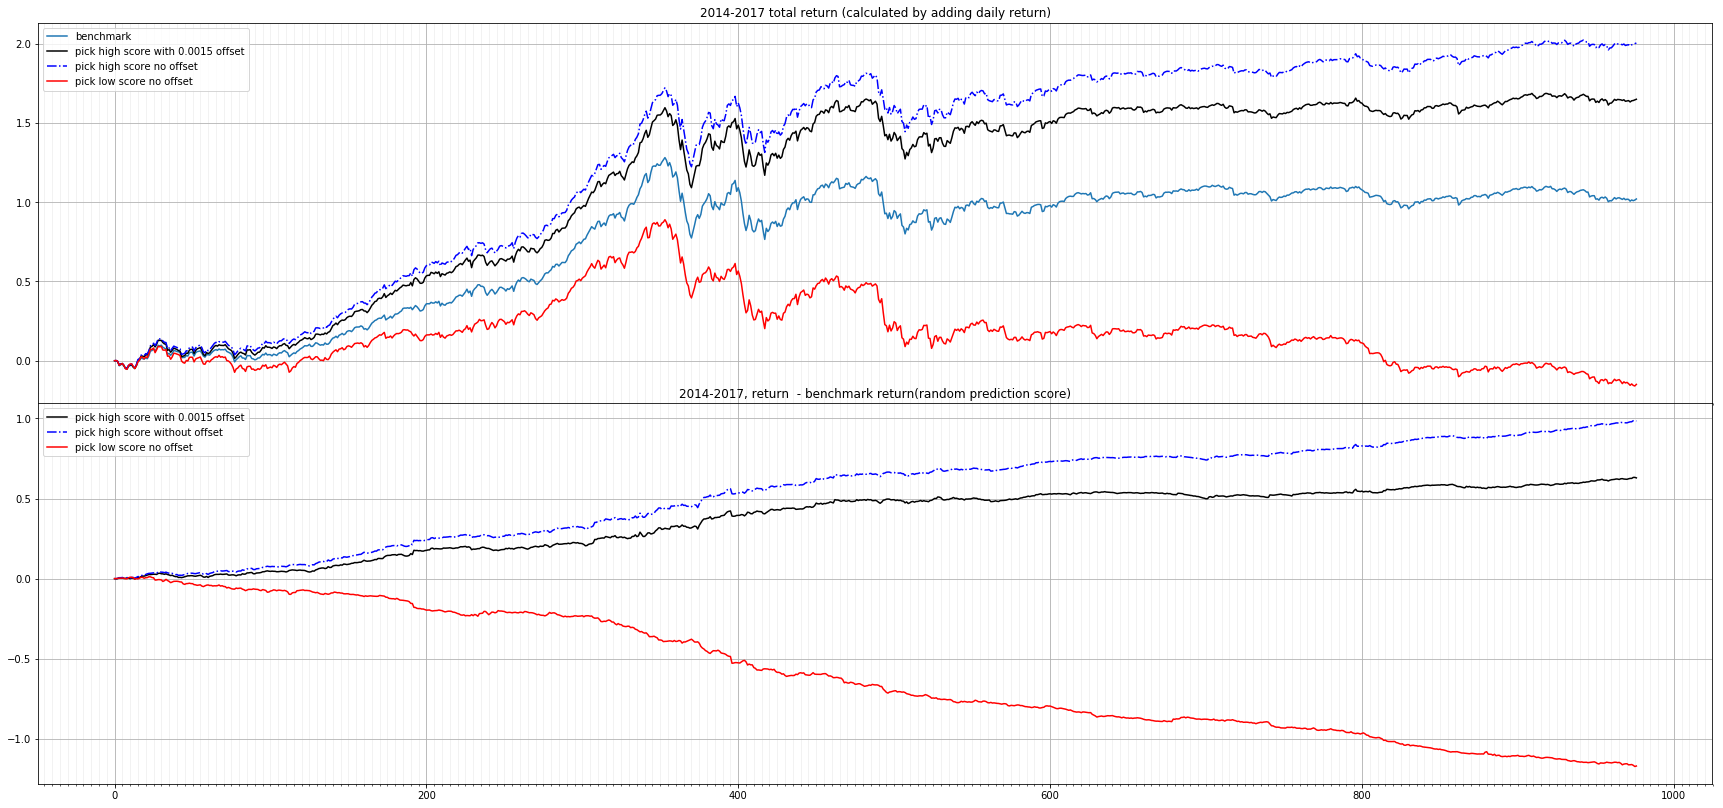

In [3]:

offset = 0.0015
start_day,end_day = '2014-01-01','2017-12-30'

benchmark = pd.read_csv('../data/backtest/benchmark_500.csv',header=0,index_col=[0])
benchmark = benchmark.loc[start_day:end_day]



actural_return_with_offset = pred_best_with_offset.acutual_return
actural_with_offset = [0]
#start_actural = 1
for i in actural_return_with_offset:
    actural_with_offset.append(actural_with_offset[-1] + i)
    
    
actural_return_without_offset = pred_best_without_offset.acutual_return
actural_without_offset = [0]
#start_actural = 1
for i in actural_return_without_offset:
    actural_without_offset.append(actural_without_offset[-1] + i)
    
    
actural_return_worst= pred_worst.acutual_return
actural_worst  = [0]
#start_actural = 1
for i in actural_return_worst:
    actural_worst.append(actural_worst[-1] + i)
    


benchmark_return = list(benchmark.iloc[:,-1])
#benchmark_start = 1
benchmark = [0]
for i in benchmark_return:
    #benchmark_start *= (1+i)
    benchmark.append(benchmark[-1] + i)


f, (ax1, ax2) = plt.subplots(2, sharex=True)
f.set_figheight(14)
f.set_figwidth(30)

ax2.plot(np.array(actural_with_offset) - np.array(benchmark),'k', label= 'pick high score with 0.0015 offset')
ax2.plot(np.array(actural_without_offset) - np.array(benchmark),'b-.',label= 'pick high score without offset')
ax2.plot(np.array(actural_worst) - np.array(benchmark),'r',label='pick low score no offset')
major_ticks = ax2.get_xticks()
minor_ticks = np.arange(major_ticks.min(),major_ticks.max(),5)
ax2.set_xticks(minor_ticks, minor=True)
ax2.grid(True)
ax2.grid(which='minor', alpha=0.2)
ax2.legend()
ax2.set_title('2014-2017, return  - benchmark return(random prediction score)')
ax1.plot(benchmark,'-',label = 'benchmark')
ax1.plot(actural_with_offset,'k',label = 'pick high score with 0.0015 offset')
ax1.plot(actural_without_offset,'b-.',label = 'pick high score no offset')
ax1.plot(actural_worst,'r',label = 'pick low score no offset')
ax1.grid(True)
ax1.grid(which='minor', alpha=0.2)
ax1.legend()
ax1.set_title('2014-2017 total return (calculated by adding daily return)')
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
plt.savefig('../figure/2014-2017 sum of daily return')

In [23]:
multi_index = pd.MultiIndex.from_product([['Sum of daily return'],['2014-2017 Return (%)', 'Return - Benchmark Return']])

result_sum = pd.DataFrame([[np.array(benchmark)[-1], (np.array(benchmark) - np.array(benchmark))[-1]], 
              [np.array(actural_with_offset)[-1], (np.array(actural_with_offset) - np.array(benchmark))[-1]],
              [np.array(actural_without_offset)[-1], (np.array(actural_without_offset) - np.array(benchmark))[-1]], 
              [np.array(actural_worst)[-1], (np.array(actural_worst) - np.array(benchmark))[-1]]
              ], columns=multi_index, 
             index=['Benchmark','Pick high score + 0.0015 offset', 'Pick high score + no offset', 'Pick low score + no offset'])



result_sum.iloc[:,:2] = result_sum.iloc[:,:2]* 100
result_sum

Sum of daily return                          
                                2014-2017 Return (%) Return - Benchmark Return
Benchmark                                 102.066916                  0.000000
Pick high score + 0.0015 offset           164.983649                 62.916732
Pick high score + no offset               200.506119                 98.439202
Pick low score + no offset                -14.938700               -117.005616

<h4> Cumulative Return</h4>

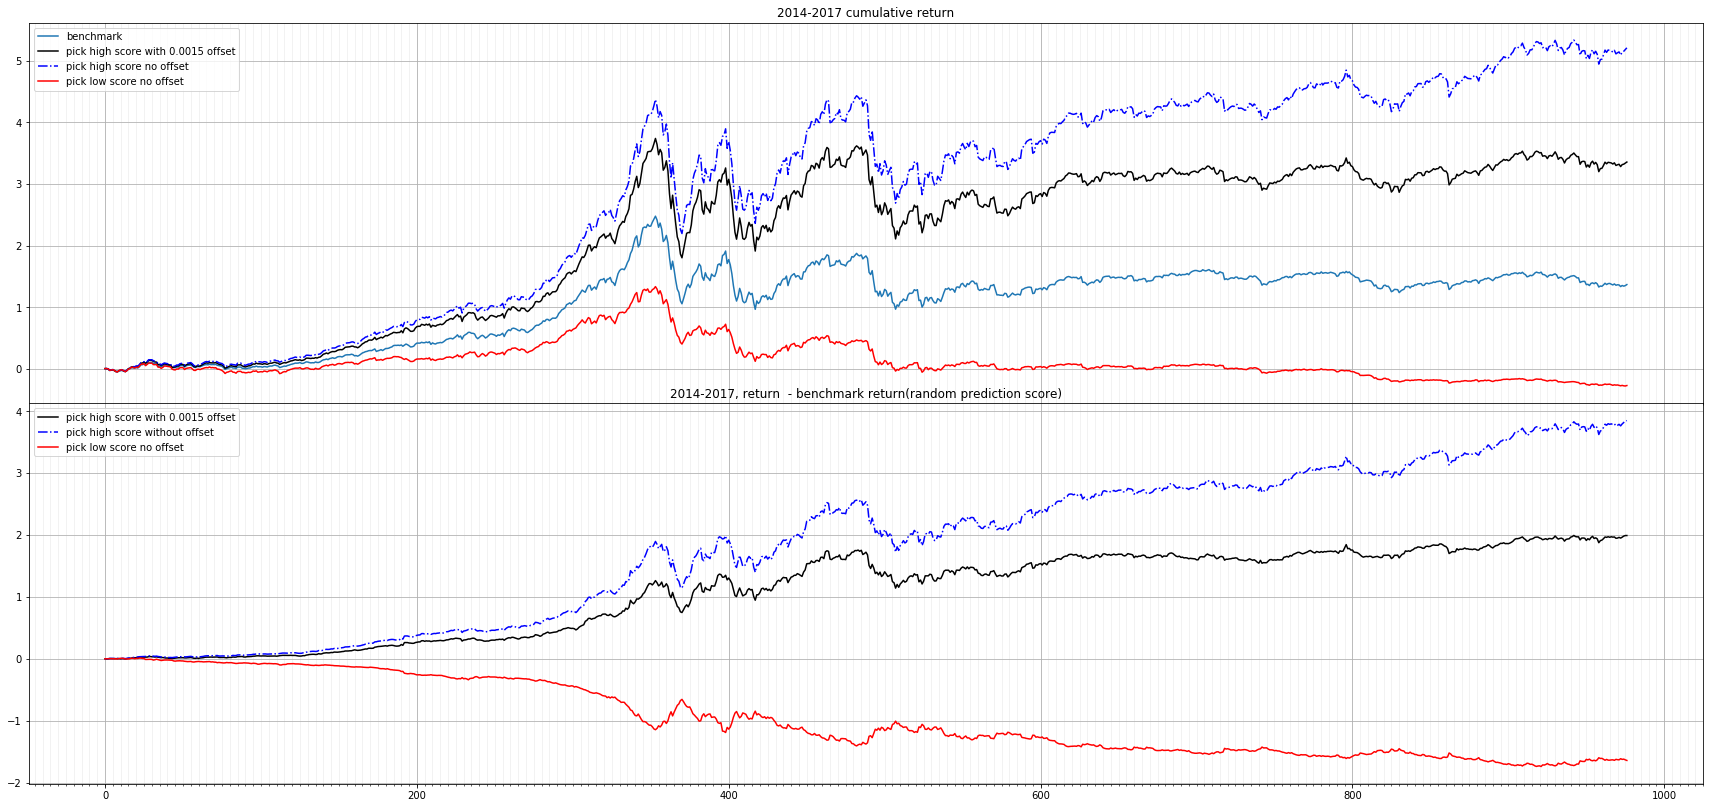

In [4]:

offset = 0.0015
start_day,end_day = '2014-01-01','2017-12-30'

benchmark = pd.read_csv('../data/backtest/benchmark_500.csv',header=0,index_col=[0])
benchmark = benchmark.loc[start_day:end_day]



actural_return_with_offset = pred_best_with_offset.acutual_return
actural_with_offset = [1]
#start_actural = 1
for i in actural_return_with_offset:
    actural_with_offset.append(actural_with_offset[-1] * (1 + i))
    
    
actural_return_without_offset = pred_best_without_offset.acutual_return
actural_without_offset = [1]
#start_actural = 1
for i in actural_return_without_offset:
    actural_without_offset.append(actural_without_offset[-1] * (1 + i))
    
    
actural_return_worst= pred_worst.acutual_return
actural_worst  = [1]
#start_actural = 1
for i in actural_return_worst:
    actural_worst.append(actural_worst[-1] * (1 + i))
    


benchmark_return = list(benchmark.iloc[:,-1])
#benchmark_start = 1
benchmark = [1]
for i in benchmark_return:
    #benchmark_start *= (1+i)
    benchmark.append(benchmark[-1] * (1 + i))


f, (ax1, ax2) = plt.subplots(2, sharex=True)
f.set_figheight(14)
f.set_figwidth(30)

ax2.plot(np.array(actural_with_offset) - np.array(benchmark),'k', label= 'pick high score with 0.0015 offset')
ax2.plot(np.array(actural_without_offset) - np.array(benchmark),'b-.',label= 'pick high score without offset')
ax2.plot(np.array(actural_worst) - np.array(benchmark),'r',label='pick low score no offset')
major_ticks = ax2.get_xticks()
minor_ticks = np.arange(major_ticks.min(),major_ticks.max(),5)
ax2.set_xticks(minor_ticks, minor=True)
ax2.grid(True)
ax2.grid(which='minor', alpha=0.2)
ax2.legend()
ax2.set_title('2014-2017, return  - benchmark return(random prediction score)')
ax1.plot(np.array(benchmark) - 1,'-',label = 'benchmark')
ax1.plot(np.array(actural_with_offset) - 1,'k',label = 'pick high score with 0.0015 offset')
ax1.plot(np.array(actural_without_offset) - 1,'b-.',label = 'pick high score no offset')
ax1.plot(np.array(actural_worst) - 1,'r',label = 'pick low score no offset')
ax1.grid(True)
ax1.grid(which='minor', alpha=0.2)
ax1.legend()
ax1.set_title('2014-2017 cumulative return')
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
plt.savefig('../figure/2014-2017 cumulative daily return')

In [28]:
multi_index = pd.MultiIndex.from_product([['Cumulative return'],['2014-2017 Return (%)', 'Return - Benchmark Return']])


result_multiplication = pd.DataFrame([[np.array(benchmark)[-1] - 1, (np.array(benchmark) - np.array(benchmark))[-1]], 
              [np.array(actural_with_offset)[-1] - 1, (np.array(actural_with_offset) - np.array(benchmark))[-1]],
              [np.array(actural_without_offset)[-1] - 1, (np.array(actural_without_offset) - np.array(benchmark))[-1]], 
              [np.array(actural_worst)[-1] - 1, (np.array(actural_worst) - np.array(benchmark))[-1]]
              ], columns=multi_index, 
             index=['Benchmark','Pick high score + 0.0015 offset', 'Pick high score + no offset', 'Pick low score + no offset'])



result_multiplication = result_multiplication * 100
result_multiplication

Cumulative return                          
                                2014-2017 Return (%) Return - Benchmark Return
Benchmark                                 136.574258                  0.000000
Pick high score + 0.0015 offset           335.678456                199.104198
Pick high score + no offset               521.282847                384.708589
Pick low score + no offset                -27.487964               -164.062223

<h3> Let's see how many stocks are bought(or sold) on average</h3>
Remeber the number of stocks sold is equal to the number of stocks bought each day, since the nnumber of stocks in our position remains 60.

In [36]:
multi_index = pd.MultiIndex.from_product([['Strategy Info'],['num of stock in positions', 'Average daily changed stocks']])

strategy_info = pd.DataFrame([['NA','NA'],
              [60,pred_best_with_offset.total_num_bought/pred_best_with_offset.num_of_buy_time],
              [60,pred_best_without_offset.total_num_bought/pred_best_without_offset.num_of_buy_time],
              [60,pred_worst.total_num_bought/pred_worst.num_of_buy_time]], 
             columns=multi_index, 
             index=['Benchmark','Pick high score + 0.0015 offset', 'Pick high score + no offset', 'Pick low score + no offset'])
strategy_info

Strategy Info  \
                                num of stock in positions   
Benchmark                                              NA   
Pick high score + 0.0015 offset                        60   
Pick high score + no offset                            60   
Pick low score + no offset                             60   

                                                              
                                Average daily changed stocks  
Benchmark                                                 NA  
Pick high score + 0.0015 offset                      7.35041  
Pick high score + no offset                          7.35041  
Pick low score + no offset                           6.19877

<h3> Final Result and Conclusion </h3>

In [35]:
pd.concat([result_sum,result_multiplication,strategy_info],axis=1)

Sum of daily return  \
                                2014-2017 Return (%)   
Benchmark                                 102.066916   
Pick high score + 0.0015 offset           164.983649   
Pick high score + no offset               200.506119   
Pick low score + no offset                -14.938700   

                                                           \
                                Return - Benchmark Return   
Benchmark                                        0.000000   
Pick high score + 0.0015 offset                 62.916732   
Pick high score + no offset                     98.439202   
Pick low score + no offset                    -117.005616   

                                   Cumulative return  \
                                2014-2017 Return (%)   
Benchmark                                 136.574258   
Pick high score + 0.0015 offset           335.678456   
Pick high score + no offset               521.282847   
Pick low score + no offset                -27.487964   

                                                           \
                                Return - Benchmark Return   
Benchmark                                        0.000000   
Pick high score + 0.0015 offset                199.104198   
Pick high score + no offset                    384.708589   
Pick low score + no offset                    -164.062223   

                                            Strategy Info  \
                                num of stock in positions   
Benchmark                                              NA   
Pick high score + 0.0015 offset                        60   
Pick high score + no offset                            60   
Pick low score + no offset                             60   

                                                              
                                Average daily changed stocks  
Benchmark                                                 NA  
Pick high score + 0.0015 offset                      7.35041  
Pick high score + no offset                          7.35041  
Pick low score + no offset                           6.19877